In [1]:
# style the notebook
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('http://bit.ly/1LC7EI7')
HTML(response.read().decode("utf-8"))

# Perceptron Learning Algorithm

** Not 'written' yet, just notes to an article**

This is a poorly performing algorithm, but it illustrates the idea of machine learning.


So the idea here is we encode information as a vector. For example, we may want to make a credit decision. Factors could include age, debt, income, and more. We cannot know if somebody is a good credit risk or not, but we have a lot of data from previous loans. We want to create a model from the past data so we can decide if we should approve a new application.

* input: x -> application
* data: N sets of previous inputs and outcomes ($\mathbf{x}_i$, $y_i$) $\text{for i in 1..N}$
* output: y -> extend credit
* target function: f: x -> y   No way to know this
* hypthothesis function: g: x -> y  we learn this

We do not know what the true target function $f$ might be. So we use machine learning to find a hypothesis function $g$, which will be *approximately* equal to $f$, or $f\approx g$.


Here is some example data. I use only two factors so I can plot it in 2 dimensional plots. Real data may have dozens to thousands of factors.

In [2]:
import numpy as np
data = np.array(((3.0, 4.0), (4.0, 6.0), (4.3, 4.0), (8.0, 7.0), 
                 (6.0, 5.5), (6.4, 8.2), (1.0, 7.0), (4.0, 5.2),  
                 (7.0, 7.5), (5.0, 2.0), (7.0, 6.0), (7.0, 3.0),
                 (6.0, 8.4), (2.0, 3.6), (1.0, 2.7)))

A **peceptron** models the hypothesis function as a sum of weights. Maybe we should weight income very high, weight debt with a large negative value, model age with a modest positive value, and so on. 

Then, for a given set of factors we multiply the weights by the factors and sum them. If the sum exceeds a threshold we approve the credit, otherwise we deny it. 

If we let $D$ be the dimension of our factors (# of factors), then the perceptron is

$$\text{approve credit if } \sum\limits_{i=1}^d w_i x_i >\text{ threshold}$$

or
$$h(\mathbf{x}) = \text{sign}\Big[\sum\limits_{i=1}^d w_i x_i - \text{threshold}\Big]$$

In other words, $h(\mathbf{x})$ will be $1$ if we approve credit, and $-1$ if we deny credit.

NumPy provides a `sign` routine, but it does not behave how we want. It returns 1 for positive numbers, -1 for negative numbers, but 0 for zero. Hence we will write our own `sign` function which uses `numpy.sign` but converts any value of 0 to 1.

In [3]:
def sign(data):
    """ numpy.sign gives 0 for sign(0), we want 1."""
    s = np.asarray(np.sign(data), dtype=int)
    s[s==0] = 1
    return s

To test our code we need to simulate the function $f$, which normally we will not know. Here I arbitrarily define it as approving the credit if the sum of the x and y factors is less than 10.5. In other words, if $x_1 + x_2 < 10.5$ that person didn't make us money, otherwise they did make us money.

In [4]:
def real_cost(data):
    return sign(data[:, 1] + data[:, 0] - 10.5)

Let's look at that in a plot. I'll write a function to plot the data points in red if they cost us money, and black if they made us money.

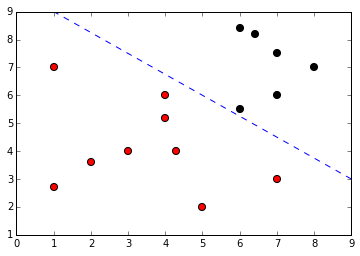

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_costs(x0, x1, y):
    for i, c in enumerate(y):  
        plt.scatter(x0[i], x1[i], c='k' if c==1 else 'r', s=50)

y = real_cost(data)
plot_costs(data[:, 0], data[:, 1], y)
plt.plot([9, 1], [3, 9], ls='--');
plt.xlim(0, 9); plt.ylim(1, 9);

I drew a dotted line through the data which separates the red from the black points. The perceptron equation is a linear combination of factors, so it can only ever linearly discriminate between groups. Thus our data must be **linearly separable** for PLA to work.

We want to implement this code using linear algebra. Because. We can get rid of the $> \text{threshold}$ term by introducing a dummy term $x_0$, which we always set to 1. We introduce a new weight $w_0$ corresponding to it. This lets us write our hypothesis function as

$$h(\mathbf{x}) = \text{sign}\Big[\sum\limits_{i=0}^d w_i x_i \Big]$$

$\sum\limits_{i=0}^d w_i x_i$ is called an **inner product** in linear algebra, and we can calculate it extremely quickly with `numpy.inner()`. It is written as

$$h(\mathbf{x}) = \mathbf{w}^\mathsf{T}\mathbf{x}$$

Here is an example for $1*4 + 2*7$ (weights are 1 and 2, x's are 4 and 7):

In [6]:
x = np.array([[4, 7]])
w = np.array([[1], 
              [2]])
np.inner(w.T, x)

array([[18]])

Alternatively we could use `numpy.dot` to compute the same value, but inner better conveys what we are doing:

In [7]:
np.dot(w.T, x.T)

array([[18]])

I prefer having my data be a vector (a column) so I am prone to write the following, and will do so in the rest of this paper:

In [8]:
x = np.array([[4], [7]])
w = np.array([[1, 2]])
np.dot(w, x)

array([[18]])

We need to add $x_0 = 1$ to our data, so let's get that out of the way so we can discuss the algorithm. Our data is stored in column format (each row is a separate record), so we need to add a column of ones to the left of the matrix `data`. The opaquely named `numpy.c_()` concatenates columns together:

In [9]:
N = len(data) # number of data records
xs = np.c_[np.ones(N), data] # add column of ones for x_0
xs

array([[ 1. ,  3. ,  4. ],
       [ 1. ,  4. ,  6. ],
       [ 1. ,  4.3,  4. ],
       [ 1. ,  8. ,  7. ],
       [ 1. ,  6. ,  5.5],
       [ 1. ,  6.4,  8.2],
       [ 1. ,  1. ,  7. ],
       [ 1. ,  4. ,  5.2],
       [ 1. ,  7. ,  7.5],
       [ 1. ,  5. ,  2. ],
       [ 1. ,  7. ,  6. ],
       [ 1. ,  7. ,  3. ],
       [ 1. ,  6. ,  8.4],
       [ 1. ,  2. ,  3.6],
       [ 1. ,  1. ,  2.7]])

Now, the algorithm. 

We start by assigning random numbers to the weight vector. Perform the inner product against our data set. Compare to actual results. Almost certainly 1 or more will be misclassified. 

Randomly take *one* of the misclassified points and 'nudge' the weight so that the point is no longer misclassified. This nudge fixes this point, but of course might cause one or more other points to become misclassified. But against that point we might also fix the categorization of some points as well.

$\mathbf{w}^\mathsf{T}\mathbf{x}$ is a linear operator - it creates a line. When we start with random  weights this is the same as creating a random line drawn through our space. It is unlikely to correctly partition our data points correctly. When we 'nudge' the weight we are shifting the line so the point is on the other side of the line. So you can visualize the algorithm as moving the line around until it correctly separates our points. 

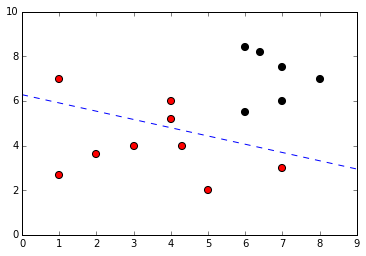

In [10]:
weights = [8.4805, -.5, -1.351]

def plot_weight_line(weights, x0, x1):
    def eq(w, x):
        """ convert w0 + w1*x + w2*y into y = mx + b"""
        return (-w[1]*x - w[0]) / w[2]
    plt.plot([x0, x1], [eq(weights, x0), eq(weights, x1)], ls='--')
     
def plot_weight_example(weights):
    plot_weight_line(weights, 0, 9)
    plot_costs(data[:, 0], data[:, 1], y)
    plt.xlim(0,9); plt.ylim(0, 10);
    
plot_weight_example(weights)

And after some weight change to move the line so that the point at (4, 5.2) is on the correct side of the line:

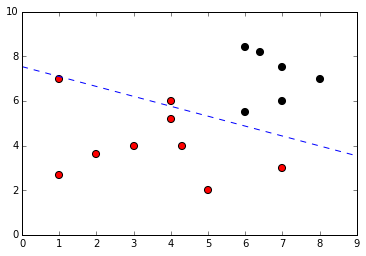

In [11]:
weights = [10.1782, -.6, -1.351]
plot_weight_example(weights)

You can see that it had the side benefit of also putting the point at (1, 7) on the right side of the line.

I caused this by carefully choosing the weights by trial and error; the algorithm uses a different technique. Lets think about the geometric interpretation of the inner product $\mathbf{w}^\mathsf{T}\mathbf{x}$.

If the inner product is positive (accept the application) then the angle formed by $\mathbf{w}$ and $\mathbf{x}$ will be acute. If the inner product is negative (deny the application) then the angle will be oblique.

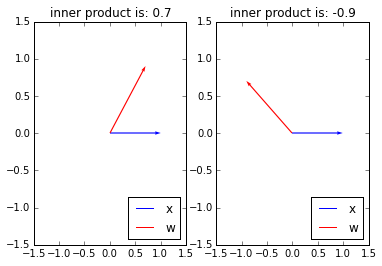

In [12]:
def plot_vector(x, c='b', label=''):
    plt.gca().quiver(0,0,x[0], x[1],angles='xy',scale_units='xy',scale=1, color=c)
    plt.plot([0], [0], color=c, label=label)

x = [1.0, 0.0]
w = [.7, 0.9]

plt.subplot(121)
plot_vector(x, 'b', 'x')
plot_vector(w, 'r', 'w')
plt.xlim(-1.5, 1.5); plt.ylim(-1.5,1.5);
plt.title('inner product is: {}'.format(np.dot(x, w)))
plt.legend(loc=4)

w = [-.9, .7]
plt.subplot(122)
plot_vector(x, 'b', 'x')
plot_vector(w, 'r', 'w')
plt.xlim(-1.5, 1.5); plt.ylim(-1.5,1.5);
plt.title('inner product is: {}'.format(np.dot(x, w)))
plt.legend(loc=4);

If the angle is acute ($h(x)$ is positive) and the point is misclassified this means the inner product is positive, but it should be negative: $y=-1$. If we add $yx$ to the weight, i.e. $-x$ the angle will be converted to an oblique angle. Likewise, if the angle is oblique ($h(x)$ is negative) and the point is misclassified then $y=+1$. If we add $yx$ to the weight, i.e $+x$ the angle will be converted to an acute angle: 

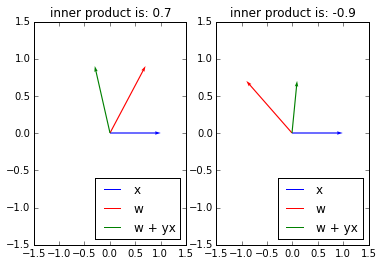

In [13]:
x = [1.0, 0.0]
w = [.7, 0.9]
wyx = [-.3, .9]

plt.subplot(121)
plot_vector(x, 'b', 'x')
plot_vector(w, 'r', 'w')
plot_vector(wyx, 'g', 'w + yx')
plt.xlim(-1.5, 1.5); plt.ylim(-1.5,1.5);
plt.title('inner product is: {}'.format(np.dot(x, w)))
plt.legend(loc=4)

w = [-.9, .7]
wyx = [.1, 0.7]
plt.subplot(122)
plot_vector(x, 'b', 'x')
plot_vector(w, 'r', 'w')
plot_vector(wyx, 'g', 'w + yx')
plt.xlim(-1.5, 1.5); plt.ylim(-1.5,1.5);
plt.title('inner product is: {}'.format(np.dot(x, w)))
plt.legend(loc=4);

Therefore our 'nudging' algorithm is very simple to implement. Choose a point such that $\text{sign}(\mathbf{w}^\mathsf{T}\mathbf{x}_n) \neq y_n$, which means it is misclassified. Update the weight with $\mathbf{w} \gets \mathbf{w} y_n\mathbf{x}_n$. 

The PLA runs in a loop:

```python

while some point is misclassified:
    randomly choose a miscategorized point i
    w = w + y_i * x_i
```

PLA is not guaranteed to converge so we need to add checks for the number of iterations, and we also need to return a `success` flag indicating whether we found an answer or not. We use `numpy.random.permutation()` to randomly iterate over the points. If you don't do this you can easily enter into an infinite loop since you can endless fix point 1, which misclassifies point 2. You fix point 2, which misclassifies point 1, ad infinitum. 

In [14]:
def PLA(xs, weights, max_iters=5000):
    misidentified = True
    success = False
    iters = 0
    indexes = range(len(xs))
    while misidentified and iters < max_iters:
        misidentified = False
        for i in np.random.permutation(indexes):
            x = xs[i]
            s = sign(np.dot(weights, x)[0])
            if s != y[i]:
                misidentified = True
                weights += np.dot(y[i], x)
                break
        success = not misidentified
        iters += 1
        
    return success, iters

final weights [[-62.32551368   7.30473617   3.49370446]]
numer of iterations 281


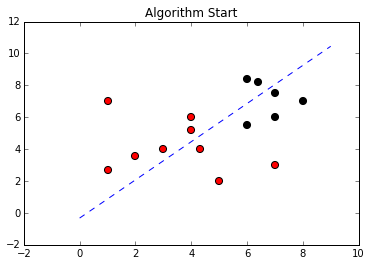

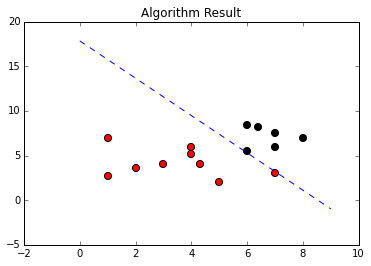

In [31]:
from numpy.random import randn

d = 2  # dimension of attributes


# I'm hard coding this to cause initial weights to be
# very bad. Uncommment next line to randomly generate weights.
weights = np.array([[-0.32551368, 1.20473617, -1.00629554]])
#weights = np.array([randn(d+1)*5 - 1.5])

# plot initial setup
plot_weight_line(weights[0, :], 0, 9)
plot_costs(xs[:, 1], xs[:, 2], y)
plt.title('Algorithm Start')

# run algorithm
success, iters = PLA(xs, weights)

# plot and print the results
plt.figure()
plot_costs(xs[:, 1], xs[:, 2], y)
print('final weights', weights)
plot_weight_line(weights[0, :], 0, 9)
plt.title('Algorithm Result')
print('numer of iterations', iters)